# Forced Pendulum Model
A forced pendulum model is presented, and a PID controller is implemented. The model represents a moving parcel with a thrust that controls and dampens oscillations.

## Pendulum Dynamics
The dynamics of the pendulum are $\ddot{\theta}+\frac{g}{L} sin(\theta) = \frac{m}{L} F$, where $\theta$ is the angle with the vertical axis, $L$ is the length of the pendulum, $m$ is the mass of the bob, and $F$ is a force applied at the bob.

Assuming $sin(\theta)=\theta$ for small angles, and redefining the term $\frac{m}{L} F$ as a control input $u$, the dynamics are rewritten as $\ddot{\theta}+\frac{g}{L} \theta = u$.

Then, for purposes of numerical integration, the 2nd order differential equation is decomposed to a system of first-order differential equations where the states $x_1, ~ x_2$ correspond to $\theta$ and $\dot{\theta}$, respectively.

Rewritten in the state-space form, the dynamics are $\dot{\textbf{x}} = \textbf{A} \textbf{x} + \textbf{B} u$, where the vector $\textbf{x} = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}$ is the state vector, $\textbf{A} = \begin{bmatrix} 0 & 1 \\ -\frac{g}{L} & 0 \end{bmatrix}$ and $\textbf{B} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$.

The observed output is $\textbf{y} = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}$.

In [7]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from scipy.integrate import odeint

In [35]:
g = 9.81 # gravity in m/s2
L = 6    # pendulum length in m
m = 1

# Define the pendulum model
def pendulum(X, t, u, g, L):
    A = np.array([[0, 1], [-g/L, 0]])
    B = np.array([0, 1])

    return np.matmul(A, X) + B*u

In [36]:
x0 = np.array([np.pi/2, 0])
t = np.linspace(0, 10, 1000)
u = 1
out = odeint(pendulum, x0, t, args=(u, g, L))
print(out)

[[ 1.57079633  0.        ]
 [ 1.57071776 -0.01569777]
 [ 1.57048207 -0.03139299]
 ...
 [ 1.55266591 -0.23733854]
 [ 1.55021313 -0.25272017]
 [ 1.54760659 -0.26806039]]


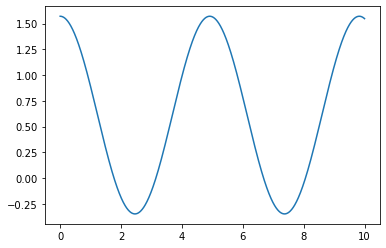

In [37]:
plot(t, out[:, 0])

Observing the response to a step input, it is clear that the system cannot be stabilized without a more sophisticated controller.

# PID Controller
A PID controller is implemented.

## Controllability

The first step is checking for the controllability of the system.

A linear system is controllable if the rank of its controllability matrix $C = \begin{bmatrix} B & AB & ... & A^{n-1} B \end{bmatrix}$ is of rank $n$, where $n$ is the number of states.

The controllability and rank can be calculated using the `control` module.

In [38]:
# Check for controllability
import control as co

# Define matrices A and B
A = np.array([[0, 1], [-g/L, 0]])
B = np.array([[0], [1]])

# Calculate the controllability matrix C
C = co.ctrb(A, B)

# Calculate the rank of C
np.linalg.matrix_rank(C)

2

A rank of 2 indicates that the system is controllable.

## PID Control Design
The PID controller is developed. The setpoint is $x_{des} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$, as a stationary parcel is the control goal.

In [39]:
# Define the setpoint
xdes = np.array([0, 0])

The PID controller is defined below.

In [40]:
def pid(Kp, Ki, Kd, X, xdes, error_prev, I):
    error = xdes - X
    
    P = np.matmul(Kp, error)
    I = I + np.matmul(Ki, error - error_prev)
    D = np.matmul(Kd, error - error_prev)

    return P + I + D, I



Tuning the values for $K_p, ~K_i, ~K_d$ is an iterative process. Below, the PID is used to stabilize the dynamics to zero using the ideal values.

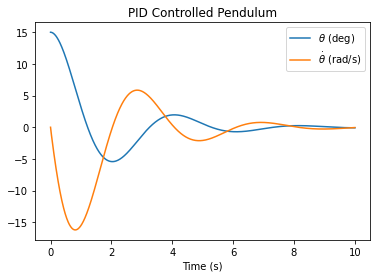

In [41]:
# Parameters
Kp = np.array([0.5, 0.5])
Ki = np.array([0.5, 0.5])
Kd = np.array([0.5, 0.5])

# Initial conditions and values
t = np.linspace(0, 10, 1000)
error = np.zeros(len(t))
x = np.zeros((2, len(t)))

x[:, 0] = np.array([15*np.pi/180, 0])
U = np.zeros(len(t))

I = 0
error_prev = 0

for i in range(len(t) - 1):
    u, I = pid(Kp, Ki, Kd, x[:, i], xdes, error_prev, I)
    error_prev = xdes - x[:, i]
    U[i] = u

    x1 = x[0, i]
    x2 = x[1, i]

    out = odeint(pendulum, [x1, x2], [t[i], t[i+1]], args=(u, g, L))
    
    x[:, i+1] = np.array([out[1, 0], out[1, 1]])

plot(t, x[0, :]*180/np.pi, label=R'$\theta$ (deg)')
plot(t, x[1, :]*180/np.pi, label=R'$\dot{\theta}$ (rad/s)')
plt.xlabel('Time (s)')
plt.legend()
plt.title("PID Controlled Pendulum")

plt.savefig("pidcontrolled.png")

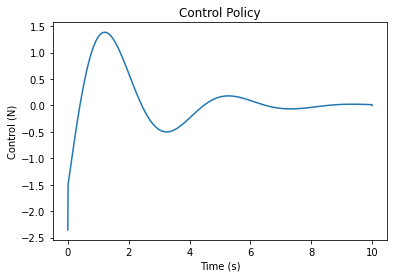

: 

In [42]:
plot(t, U*L/m)
plt.title('Control Policy')
plt.xlabel('Time (s)')
plt.ylabel('Control (N)')

plt.savefig("controlpolicy.png")

The PID controller shows a control policy with a maximum required thrust magnitude of 4.5 N; this value falls within the reasonable bounds of the thrust force developed by a propeller.

# PID with Wind Excitation

The PID controller is model with a maximum wind excitation of 

# Spherial Pendulum Model

A more realistic spherical model is shown here. The equation of motion takes the form 

$$\ddot{\theta}-\dot{\phi}^2 cos \theta sin \theta + \frac{g}{L} sin \theta = 0$$
$$\ddot{\phi} sin \theta + 2 \dot{\theta} \dot{\phi} cos \theta = 0$$

Lorem ipsum blah blah blah